(example_4)=
# Example 4: Learning causal coupling

Author contribution: Lina Walkowiak

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_3_Multi_armed_bandit.ipynb)

In [59]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark



In [60]:
%load_ext autoreload
%autoreload 2

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import pandas as pd
from jax import jit, vjp
from jax.tree_util import Partial
from pyhgf.math import binary_surprise
from pyhgf.model.network import Network
from pyhgf.utils import beliefs_propagation
from pyhgf.typing import AdjacencyLists
from pytensor.graph import Apply, Op
from pyhgf.updates.edges import calculate_mutual_information_sampled


np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction
In this notebook, we implement a model that incorporates causal coupling. 
First, the theory of the causal couplign mechanisms will be outlined before then implementing the functions on simulated data. We simulate two time series, where one has a causal influence on the other, differeing in its strength. The model then takes two time series as input, which are provided to the two continuous state nodes that are causally coupled. The strength of this coupling is dynamically updated based on the provided observations. 


## Theory

## Sigmoid function for updating the coupling strength
### Sequence of steps
1. The parent's node expected mean will be used by the child to inform its own prediction, weighted by the causal coupling strength (and the parent's precision).
2. The child makes an observation and compares it to its expectation. Specifically, it evaluates wherther the causal parent's own prediction reliably informed the own prediction.
3. The coupling strength is updated based on the prediction error and at the child node. If the parent's prediction successfully informed the child's prediction, the causal coupling strength is increased (i.e, moving it closer to zero). If it didn't, the strength is weakened. 


#### Mathematical equation: 

\begin{equation}
\gamma_{ci,a}^{(k+1)}​=\gamma_{ci,a}^{(k)} + \eta  \cdot \frac{1}{1+exp(−\delta_a^{(C)}​)}​
\end{equation}
where: 
- $\gamma_{ci,a}$ is the causal coupling weight
- $\eta$ is the learning rate
- $\delta_a^{(C)}$ is the prediction error due to the parent's prediction influence 

## Information theoretic approaches

## Simulating a data set


We model two binary time series, Series A and Series B, where the causal influence of A on B varies over time. We establish different levels of causal strenggth: 
high, medium, and low. These affect the likelihood of B given the state of A. 


In [61]:
# Define contingencies
high, medium, low = 0.8, 0.5, 0.2

# Stable contingencies: Each level (low, medium, high) repeats for a block of 40 time steps
stable_contingencies = np.array([low, medium, high]).repeat(50)

# Alternating contingencies: Each level repeats for 10 time steps, cycling 6 times for each level
alternating_contingencies = np.tile(np.array([low, medium, high]).repeat(10), 5)

# Combine both stable and alternating contingencies
causal_influence_sequence = np.concatenate([stable_contingencies, alternating_contingencies])

# Generate binary series independently
n_samples = len(causal_influence_sequence)
series_A = np.random.choice([0, 1], size=n_samples) 

# generate binary series with influence from the series A dependent on the strength of the current block
series_B = np.zeros(n_samples)
for i in range(n_samples):
    causal_effect = causal_influence_sequence[i]
    # Select causal effect and inverse of causal effect based on whether A is 0 or 1 
    prob_B_given_A = causal_effect if series_A[i] == 1 else (1 - causal_effect)
    series_B[i] = np.random.choice([0, 1], p=[1 - prob_B_given_A, prob_B_given_A])

/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_76790/1309979409.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


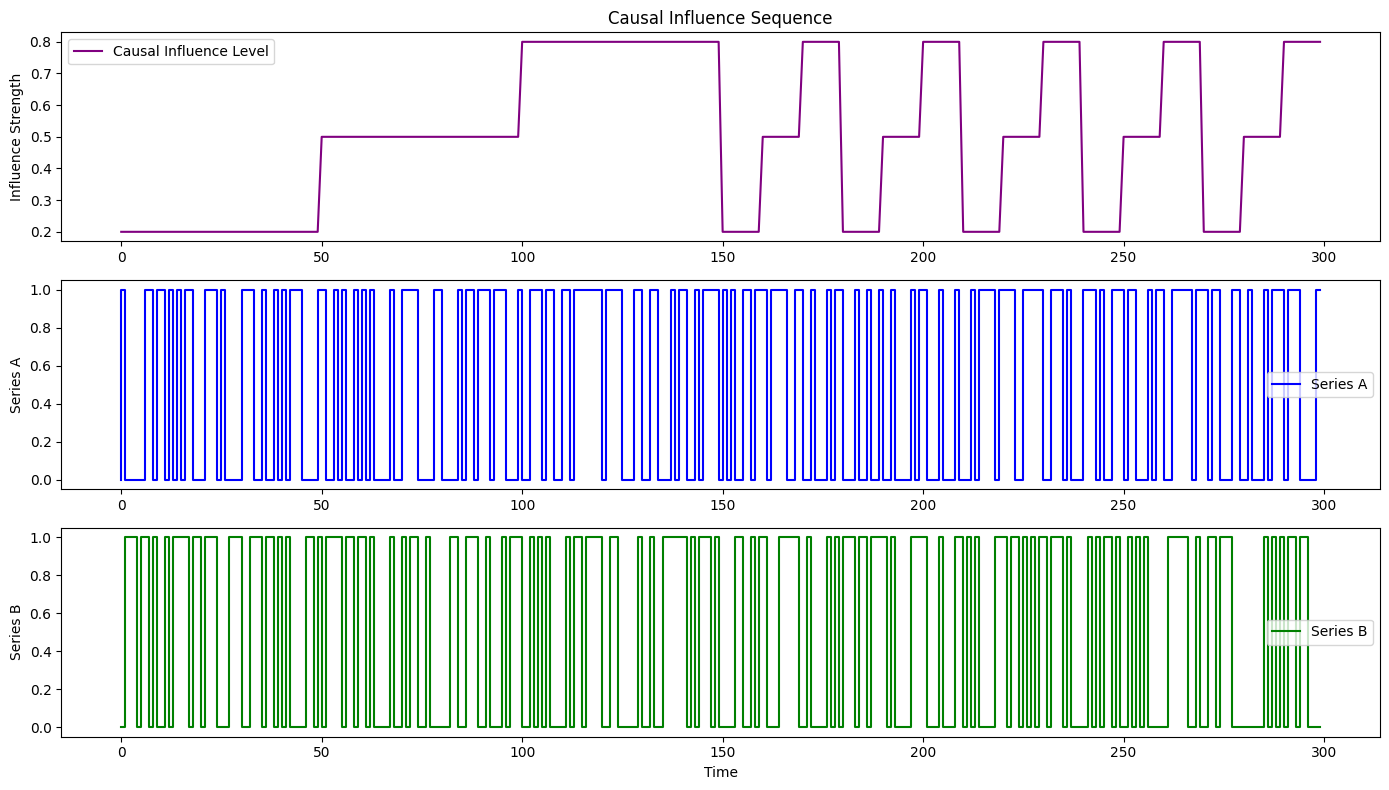

In [62]:
# Plot the time series and contingency blocks 
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(causal_influence_sequence, color='purple', label='Causal Influence Level')
plt.title("Causal Influence Sequence")
plt.ylabel("Influence Strength")
plt.legend()

plt.subplot(3, 1, 2)
plt.step(range(n_samples), series_A, color='blue', label='Series A')
plt.ylabel("Series A")
plt.legend()

plt.subplot(3, 1, 3)
plt.step(range(n_samples), series_B, color='green', label='Series B')
plt.xlabel("Time")
plt.ylabel("Series B")
plt.legend()

plt.tight_layout()
plt.show()

#### Testing the new functions: Mutual information of child node

In [65]:
parameters = {"expected_precision": 1.0} 
attributes = [
    {"expected_precision": 0.8, "expected_mean": 1, "value_coupling_children": [1]},   # Node 0
    {"expected_precision": 1.0, "expected_mean": 2, "value_coupling_children": [0.1]},   # Node 1
    {"expected_precision": 0.8,  "expected_mean": 3, "value_coupling_children": [0.5]}       # Node 2
]

edges = [
    AdjacencyLists(0, (), (1,), None, None, None),   # Node 0 has 1 as child
    AdjacencyLists(1, (0,), (2,), None, None, None), # Node 1 has Node 2 as child
    AdjacencyLists(2, (1,), (), None, None, None)    
]
# 0 -> 1 -> 2

# we calculate the mutual information for node 1
mutual_info_sampled1 = calculate_mutual_information_sampled(attributes, edges, 1)
mutual_info_sampled2 = calculate_mutual_information_sampled(attributes, edges, 2)
print(mutual_info_sampled1)
print(mutual_info_sampled2)


{'parent_child': {(0, 1): 0.028640141365105627}, 'parent_parent': {}, 'self': {1: 1.4189385332046727}}
{'parent_child': {(1, 2): 0.06112176765681369}, 'parent_parent': {}, 'self': {2: 1.5305103088617775}}


## System configuration

In [64]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Nov 05 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pyhgf : 0.0.0
jax   : 0.4.35
jaxlib: 0.4.35

pytensor  : 2.25.5
pymc      : 5.17.0
arviz     : 0.20.0
pyhgf     : 0.0.0
jax       : 0.4.35
IPython   : 8.29.0
numpy     : 1.26.0
seaborn   : 0.13.2
matplotlib: 3.9.2
pandas    : 2.2.3
sys       : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]

Watermark: 2.5.0

